In [2]:
import os
import math
import warnings
import numpy as np
import pandas as pd
import geopandas as gpd
import networkx as nx
import pyomo.environ as pyo
import folium
import osmnx as ox
from shapely.geometry import Point

warnings.filterwarnings("ignore", category=UserWarning)
ox.settings.log_console = True
ox.settings.use_cache = True

# Config
PLACE_NAME = "Nairobi, Kenya"
TIME_THRESHOLDS_MIN = [10, 15, 20]   # minutes
HEX_SIZE_KM = 1.2
RESULTS_DIR = "results"
os.makedirs(RESULTS_DIR, exist_ok=True)



In [5]:
def km_to_deg(km: float) -> float:
    # rough conversion for small area near equator
    return km / 111.32

def build_hex_grid(boundary_gdf: gpd.GeoDataFrame, hex_km: float) -> gpd.GeoDataFrame:
    """Return centroids of a hex grid clipped to the boundary (EPSG:4326)."""
    poly = boundary_gdf.geometry.union_all()  # Shapely 2+
    minx, miny, maxx, maxy = poly.bounds

    dx = km_to_deg(hex_km)
    dy = dx * math.sqrt(3) / 2

    xs = np.arange(minx - dx, maxx + dx, dx)
    ys = np.arange(miny - dy, maxy + dy, dy)

    points = []
    for j, y in enumerate(ys):
        offset = 0 if j % 2 == 0 else dx / 2
        for x in xs:
            points.append(Point(x + offset, y))

    pts_gdf = gpd.GeoDataFrame(geometry=points, crs="EPSG:4326")
    pts_gdf = pts_gdf[pts_gdf.within(poly)].reset_index(drop=True)
    pts_gdf["id"] = [f"d{idx:04d}" for idx in range(len(pts_gdf))]
    pts_gdf["weight"] = 1.0
    return pts_gdf[["id", "weight", "geometry"]]


In [6]:
# Fetch Nairobi boundary and keep in WGS84
boundary = ox.geocode_to_gdf(PLACE_NAME).to_crs("EPSG:4326")
polygon = boundary.geometry.union_all()

print("Boundary OK:", len(boundary), "polygon(s)")


Boundary OK: 1 polygon(s)


In [7]:
# Increase network timeouts for heavier downloads
ox.settings.timeout = 180

# Download/simplify drive graph, add speeds and travel times (seconds)
G = ox.graph_from_polygon(polygon, network_type="drive", retain_all=True, simplify=True)
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)

print("Graph nodes/edges:", len(G.nodes), len(G.edges))


c:\Users\HP\anaconda3\envs\optimiser-env\Lib\site-packages\osmnx\_overpass.py:359: FutureWarning: `settings.timeout` is deprecated and will be removed in the v2.0.0 release: use `settings.requests_timeout` instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  overpass_settings = _make_overpass_settings()
c:\Users\HP\anaconda3\envs\optimiser-env\Lib\site-packages\osmnx\_overpass.py:369: FutureWarning: `settings.timeout` is deprecated and will be removed in the v2.0.0 release: use `settings.requests_timeout` instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  yield _overpass_request(data={"data": query_str})


Graph nodes/edges: 37232 90724


In [8]:
# One Overpass query using OR semantics on values
tags = {
    "shop": ["mall", "supermarket"],  # shop=mall OR shop=supermarket
    "amenity": "supermarket"          # OR amenity=supermarket
}

def fetch_pois_with_retry(polygon, tags, n_retries=3, wait=10):
    last_err = None
    for k in range(n_retries):
        try:
            g = ox.features_from_polygon(polygon, tags=tags)
            if g is not None and len(g) > 0:
                return g
            last_err = RuntimeError("Empty result from Overpass for given tags.")
        except Exception as e:
            last_err = e
        time.sleep(wait * (k + 1))  # backoff
    raise last_err

pois = fetch_pois_with_retry(polygon, tags, n_retries=3, wait=10)

# Normalize geometry to points (centroids for polygons)
candidates = pois.to_crs("EPSG:4326").copy()
candidates["geometry"] = candidates.geometry.centroid
candidates = candidates.drop_duplicates(subset=["geometry"]).reset_index(drop=True)
candidates["id"] = [f"s{idx:04d}" for idx in range(len(candidates))]

print("Candidates fetched:", len(candidates))
display(candidates.head(10)[[c for c in ["id","name","geometry"] if c in candidates.columns]])


c:\Users\HP\anaconda3\envs\optimiser-env\Lib\site-packages\osmnx\_overpass.py:285: FutureWarning: `settings.timeout` is deprecated and will be removed in the v2.0.0 release: use `settings.requests_timeout` instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  overpass_settings = _make_overpass_settings()
c:\Users\HP\anaconda3\envs\optimiser-env\Lib\site-packages\osmnx\_overpass.py:395: FutureWarning: `settings.timeout` is deprecated and will be removed in the v2.0.0 release: use `settings.requests_timeout` instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  yield _overpass_request(data={"data": query_str})


Candidates fetched: 395


C:\Users\HP\AppData\Local\Temp\ipykernel_4532\1805906704.py:24: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  candidates["geometry"] = candidates.geometry.centroid


,id,name,geometry
0,s0000,Carrefour,POINT (36.76304 -1.29825)
1,s0001,Carrefour,POINT (36.80187 -1.26143)
2,s0002,Naivas Supermarket,POINT (36.83488 -1.31645)
3,s0003,Nakumatt Embakasi Supermarket,POINT (36.88916 -1.32951)
4,s0004,Nakumatt Highridge,POINT (36.81855 -1.25964)
5,s0005,Chandarana Food Plus Supermarket Ltd.,POINT (36.81787 -1.25938)
6,s0006,Fairlane,POINT (36.80201 -1.30682)
7,s0007,Onn The Way Supermarket Muthaiga,POINT (36.82025 -1.24999)
8,s0008,LainiI Saba Market,POINT (36.79582 -1.31039)
9,s0009,Kaloki Super Market,POINT (36.79768 -1.31222)


In [9]:
demand = build_hex_grid(boundary, HEX_SIZE_KM)
print("Demand points:", len(demand))
display(demand.head())
# Map visualization

Demand points: 560


,id,weight,geometry
0,d0000,1.0,POINT (36.95575 -1.43555)
1,d0001,1.0,POINT (36.91803 -1.42621)
2,d0002,1.0,POINT (36.92881 -1.42621)
3,d0003,1.0,POINT (36.93958 -1.42621)
4,d0004,1.0,POINT (36.95036 -1.42621)


In [10]:
def nearest_nodes(G, gdf_points):
    return ox.distance.nearest_nodes(G, gdf_points.geometry.x, gdf_points.geometry.y)

def compute_reach_sets(G, cand_nodes, demand_nodes, thresholds_min):
    node_to_dem = {}
    for j, dn in enumerate(demand_nodes):
        node_to_dem.setdefault(int(dn), []).append(j)
    cover = {}
    for tmin in thresholds_min:
        cutoff = tmin * 60
        cover[tmin] = {j: [] for j in range(len(demand_nodes))}
        for i, cn in enumerate(cand_nodes):
            lengths = nx.single_source_dijkstra_path_length(G, cn, weight="travel_time", cutoff=cutoff)
            for node_id in lengths:
                if node_id in node_to_dem:
                    for j in node_to_dem[node_id]:
                        cover[tmin][j].append(i)
    return cover

def solve_set_cover(num_sites, num_demands, cover_dict):
    model = pyo.ConcreteModel()
    model.I = pyo.RangeSet(0, num_sites-1)
    model.J = pyo.RangeSet(0, num_demands-1)
    model.y = pyo.Var(model.I, domain=pyo.Binary)

    def cover_rule(m, j):
        if len(cover_dict[j]) > 0:
            return sum(m.y[i] for i in cover_dict[j]) >= 1
        return pyo.Constraint.Skip
    model.cover = pyo.Constraint(model.J, rule=cover_rule)
    model.obj = pyo.Objective(expr=sum(model.y[i] for i in model.I), sense=pyo.minimize)

    solver = pyo.SolverFactory("highs")  # or "cbc", "glpk"
    solver.solve(model)
    picks = [i for i in range(num_sites) if pyo.value(model.y[i]) > 0.5]
    return picks


In [11]:
cand_nodes = nearest_nodes(G, candidates)
dem_nodes = nearest_nodes(G, demand)
cover_maps = compute_reach_sets(G, cand_nodes, dem_nodes, TIME_THRESHOLDS_MIN)

results = {}
for t in TIME_THRESHOLDS_MIN:
    picks = solve_set_cover(len(candidates), len(demand), cover_maps[t])
    results[t] = picks
    print(f"{t} min -> {len(picks)} sites selected")


10 min -> 11 sites selected
15 min -> 5 sites selected
20 min -> 3 sites selected


In [12]:

RESULTS_DIR = "results"
os.makedirs(RESULTS_DIR, exist_ok=True)

# save selected sites per scenario (drop geometry for easy CSV view)
for t, picks in results.items():
    out = candidates.iloc[picks].copy()
    out["scenario_min"] = t
    out.drop(columns="geometry").to_csv(f"{RESULTS_DIR}/selected_sites_{t}min.csv", index=False)

# coverage summary
summary = pd.DataFrame({
    "scenario_min": list(results.keys()),
    "selected_sites": [len(results[t]) for t in results],
    "total_candidates": len(candidates),
    "total_demand": len(demand),
})
summary.sort_values("scenario_min").to_csv(f"{RESULTS_DIR}/coverage_summary.csv", index=False)
summary.sort_values("scenario_min")


,scenario_min,selected_sites,total_candidates,total_demand
0,10,11,395,560
1,15,5,395,560
2,20,3,395,560


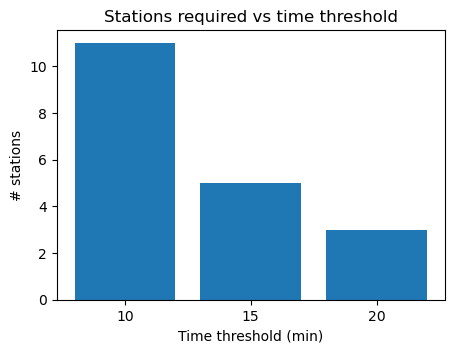

In [14]:
import matplotlib.pyplot as plt

# Visualization of one scenario
s = summary.sort_values("scenario_min")
plt.figure(figsize=(5,3.5))
plt.bar(s["scenario_min"].astype(str), s["selected_sites"])
plt.title("Stations required vs time threshold")
plt.xlabel("Time threshold (min)")
plt.ylabel("# stations")
plt.show()


In [15]:
# Map visualization
center = [boundary.geometry.centroid.y.values[0], boundary.geometry.centroid.x.values[0]]
m = folium.Map(location=center, zoom_start=11, control_scale=True)

# layer: all candidates
cand_layer = folium.FeatureGroup(name="All candidates", show=False)
for _, r in candidates.iterrows():
    folium.CircleMarker([r.geometry.y, r.geometry.x], radius=3, color="#555", fill=True, fill_opacity=0.9,
                        popup=str(r.get("name", r["id"]))).add_to(cand_layer)
cand_layer.add_to(m)

# selected per scenario
colors = {10: "red", 15: "blue", 20: "green"}
for t, picks in results.items():
    layer = folium.FeatureGroup(name=f"Selected sites ({t} min)", show=(t==min(results)))
    for i in picks:
        rr = candidates.iloc[i]
        folium.Marker([rr.geometry.y, rr.geometry.x],
                      popup=f"{rr.get('name', rr['id'])} ({t}min)",
                      icon=folium.Icon(color=colors[t])).add_to(layer)
    layer.add_to(m)

folium.LayerControl(collapsed=False).add_to(m)
m  # display in notebook

# and save
html_path = f"{RESULTS_DIR}/nairobi_charging_map.html"
m.save(html_path)
print("Saved:", html_path)


C:\Users\HP\AppData\Local\Temp\ipykernel_4532\3514785491.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center = [boundary.geometry.centroid.y.values[0], boundary.geometry.centroid.x.values[0]]


Saved: results/nairobi_charging_map.html
